### Import packages

In [37]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})


seed = 0
np.random.seed(seed)
from utils_diff_ch import *

In [61]:
def scatter(x, colors, class_list = ['ship', 'iceberg']):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i, text in enumerate(class_list):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(text), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

### Load and Prepare Data

In [223]:
def scale_range (input_, min_, max_):
    input_ += -(np.min(input_))
    input_ /= np.max(input_) / (max_ - min_)
    input_ += min_
    return input_

In [230]:
data = pd.read_json('./Data/train.json')
test = pd.read_json('./Data/test.json')

In [231]:
data['band_1'] = data['band_1'].apply(lambda x : np.array(x).reshape(75, 75))
data['band_2'] = data['band_2'].apply(lambda x : np.array(x).reshape(75, 75))

test['band_1'] = test['band_1'].apply(lambda x : np.array(x).reshape(75, 75))
test['band_2'] = test['band_2'].apply(lambda x : np.array(x).reshape(75, 75))

data['inc_angle'] = pd.to_numeric(data['inc_angle'], errors='coerce')
# data = data.dropna(axis=0, how='any')

test['inc_angle'] = pd.to_numeric(test['inc_angle'], errors='coerce')
test['not_machine_generated'] = test['inc_angle'].apply(lambda x: len(str(x))) <= 7

# Keeping only probable non-machine generated images
test = test[test['not_machine_generated']]

In [233]:
band_1 = np.concatenate([im for im in data['band_1']]).reshape(-1, 75, 75)
band_2 = np.concatenate([im for im in data['band_2']]).reshape(-1, 75, 75)
X_train = np.stack((band_1, band_2), axis=1)
X_train_angle = np.array(data['inc_angle']).reshape((len(data), 1))

band_1_test = np.concatenate([im for im in test['band_1']]).reshape(-1, 75, 75)
band_2_test = np.concatenate([im for im in test['band_2']]).reshape(-1, 75, 75)
X_test = np.stack((band_1_test, band_2_test), axis=1)
X_test_angle = np.array(test['inc_angle']).reshape((len(test), 1))

y_train = data['is_iceberg'].values.astype(np.float32)

### EDA using T-SNE and Seaborn!!

#### Training Images

In [234]:
# Reorder according to class
band_1_tsne = np.vstack([band_1[np.where(y_train==i)]
               for i in range(2)]).reshape((len(band_1), 75*75))
band_2_tsne = np.vstack([band_2[np.where(y_train==i)]
               for i in range(2)]).reshape((len(band_2), 75*75))
X_train_tsne = np.vstack([X_train[np.where(y_train==i)]
               for i in range(2)]).reshape((len(X_train), 2*75*75))
y_train_tsne = y_train.copy()
y_train_tsne.sort()

In [235]:
digits_proj_band_1 = TSNE(random_state=seed).fit_transform(band_1_tsne)
digits_proj_band_2 = TSNE(random_state=seed).fit_transform(band_2_tsne)
digits_proj_X_train = TSNE(random_state=seed).fit_transform(X_train_tsne)

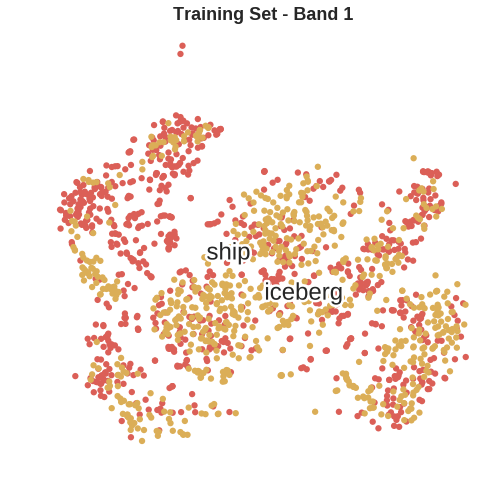

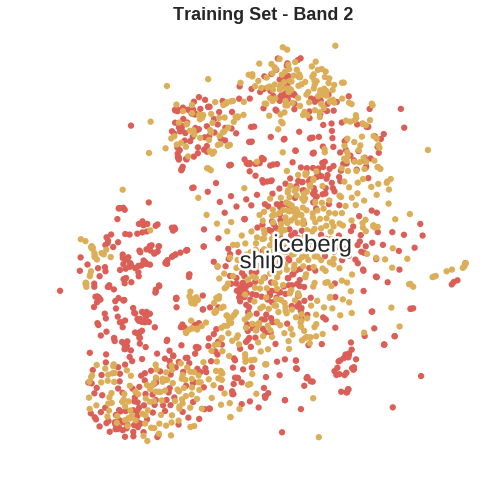

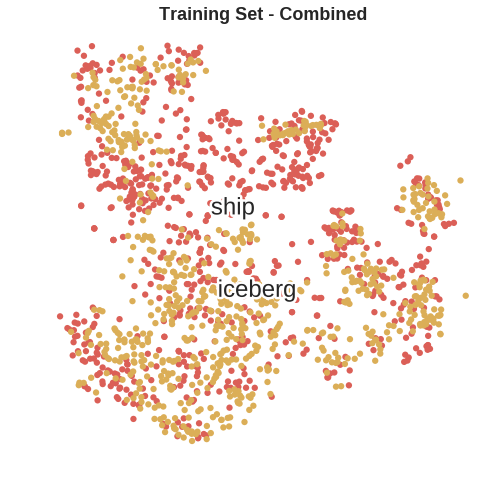

In [77]:
scatter(digits_proj_band_1, y_train_tsne)
plt.title('Training Set - Band 1', fontweight='bold')
scatter(digits_proj_band_2, y_train_tsne)
plt.title('Training Set - Band 2', fontweight='bold')
scatter(digits_proj_X_train, y_train_tsne)
plt.title('Training Set - Combined', fontweight='bold')
plt.show()

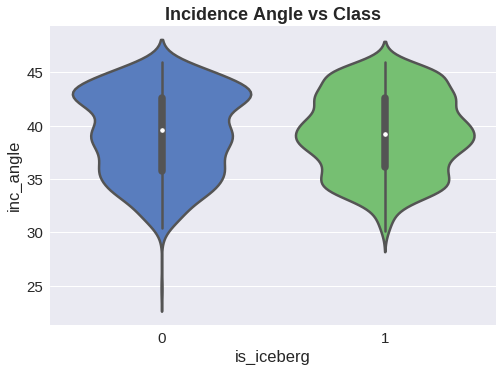

In [90]:
sns.violinplot(x='is_iceberg', y='inc_angle', data=data)
plt.title('Incidence Angle vs Class', fontweight='bold')
plt.show()

#### Compare train and test images' distributions

In [78]:
# Assign classes 0 & 1 to train and test respectively and order according to class
band_1_compare_tsne = np.vstack([band_1, band_1_test]).reshape((len(band_1)+len(band_1_test), 75*75))
band_2_compare_tsne = np.vstack([band_2, band_2_test]).reshape((len(band_2)+len(band_2_test), 75*75))
combined_compare_tsne = np.vstack([X_train, X_test]).reshape((len(band_2)+len(band_2_test), 2*75*75))
y_compare_tsne = np.concatenate((np.zeros((len(X_train))), np.ones((len(X_test)))))

In [79]:
digits_proj_compare_band_1 = TSNE(random_state=seed).fit_transform(band_1_compare_tsne)
digits_proj_compare_band_2 = TSNE(random_state=seed).fit_transform(band_2_compare_tsne)
digits_proj_compare_combined = TSNE(random_state=seed).fit_transform(combined_compare_tsne)

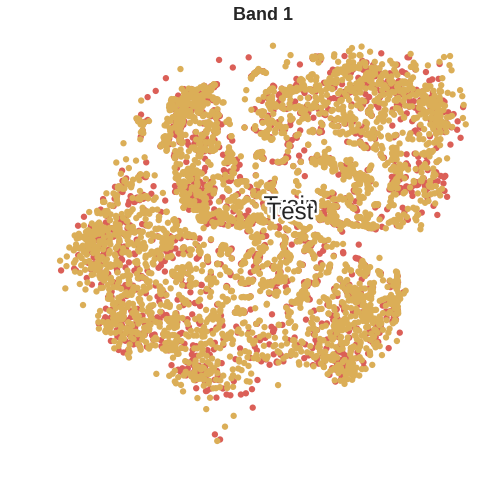

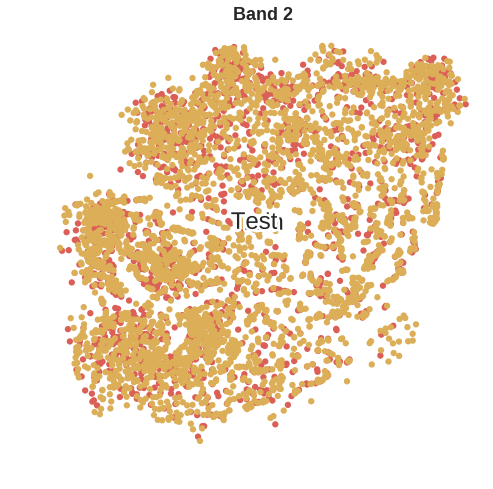

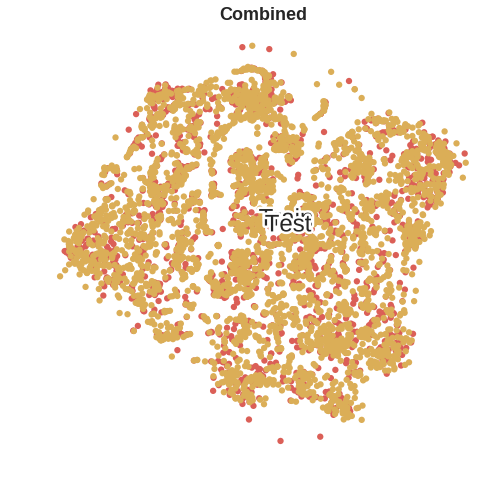

In [80]:
scatter(digits_proj_compare_band_1, y_compare_tsne, ['Train', 'Test'])
plt.title('Band 1', fontweight='bold')
scatter(digits_proj_compare_band_2, y_compare_tsne, ['Train', 'Test'])
plt.title('Band 2', fontweight='bold')
scatter(digits_proj_compare_combined, y_compare_tsne, ['Train', 'Test'])
plt.title('Combined', fontweight='bold')
plt.show()

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


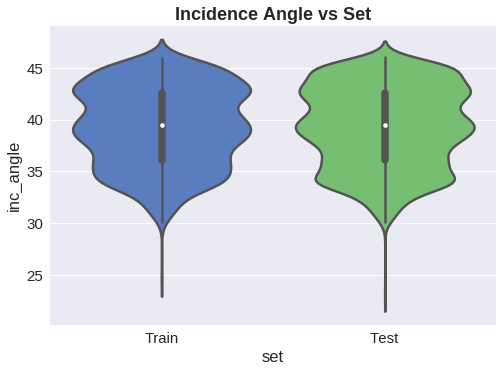

In [123]:
data['set'] = 'Train'
test['set'] = 'Test'
combined_data = data.append(test)
combined_data['inc_angle'] = pd.to_numeric(combined_data['inc_angle'], errors='coerce')
sns.violinplot(x='set', y='inc_angle', data=combined_data)
plt.title('Incidence Angle vs Set', fontweight='bold')
plt.show()